# Regressione multipla con Stan {#sec-stan-multreg}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_multiple_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

In questo capitolo introdurremo il modello di regressione multipla mostrando come possa essere implementato in Stan. Ci concentreremo sull'interpretazione dei coefficienti parziali di regressione.

## Regressione multipla

La regressione multipla rappresenta un'estensione del modello di regressione semplice, e permette di esplorare e quantificare le relazioni tra una variabile dipendente e più variabili indipendenti. Passando dal modello semplice $y = a + bx + \text{errore}$ al modello più generale $y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \text{errore}$, emergono nuove complessità. Queste includono le decisioni su quali predittori $x$ includere nel modello, l'interpretazione dei coefficienti e delle loro interazioni, e la costruzione di nuovi predittori a partire dalle variabili esistenti per catturare elementi di discrezionalità e non linearità. 

I coefficienti di regressione, in un contesto di regressione multipla, sono tipicamente più complicati da interpretare rispetto a quelli di un modello con un solo predittore. L'interpretazione di un dato coefficiente, infatti, è parzialmente condizionata dalle altre variabili presenti nel modello. Il coefficiente $\beta_k$ rappresenta la differenza media o attesa nella variabile risposta $y$, confrontando due individui che differiscono di un'unità nel predittore $x_k$ ma sono identici per quanto riguarda gli altri predittori. Questo concetto è talvolta sintetizzato con l'espressione "confrontare due osservazionni (o persone) che differiscono per $x_k$ a parità delle altre variabili".

Dal punto di vista dell'implementazione con Stan, l'estensione del modello per includere molteplici predittori dell'intelligenza del bambino è relativamente semplice. È necessario costruire una matrice $X$ contenente le colonne che rappresentano i vari predittori che intendiamo analizzare. Per l'esempio specifico in questione, i predittori selezionati per l'intelligenza del bambino includono: la scolarità della madre (codificata come 0 o 1 a seconda che la madre abbia completato o meno le scuole superiori), l'intelligenza della madre e l'età della madre. Prima di procedere con l'analisi, è importante standardizzare tutte queste variabili per facilitare l'interpretazione dei risultati e migliorare la stabilità numerica del modello.

## Un esempio pratico

Per fare un esempio pratico, analizzeremo nuovamente i dati sull'intelligenza di un gruppo di bambini. In questo caso, cercheremo di predire l'intelligenza media dei bambini considerando tre fattori: se le madri hanno completato la scuola superiore, l'intelligenza della madre e l'età della madre.

Importiamo i dati:

In [2]:
kidiq = pd.read_stata("../../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Compiliamo e stampiamo il modello Stan di regressione multipla per questi dati. Il modello assume che i dati siano standardizzati.

In [3]:
stan_file = os.path.join(project_directory, "stan", "mreg.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
    int<lower=1> N;   // Numero di osservazioni
    int<lower=1> K;   // Numero di variabili indipendenti, intercetta inclusa
    vector[N] x1;     // Prima variabile indipendente
    vector[N] x2;     // Seconda variabile indipendente
    vector[N] x3;     // Seconda variabile indipendente
    // Aggiungi altri vettori se ci sono più variabili indipendenti
    vector[N] y;      // Vettore della variabile dipendente
}
parameters {
    real alpha;           // Intercetta
    real beta1;           // Coefficiente per la prima variabile indipendente
    real beta2;           // Coefficiente per la seconda variabile indipendente
    real beta3;           // Coefficiente per la terza variabile indipendente
    // Definisci altri real per ulteriori coefficienti
    real<lower=0> sigma;  // Errore del modello
}
model {
    // Prior
    alpha ~ student_t(3, 0, 2.5);
    beta1 ~ student_t(3, 0, 2.5);
    beta2 ~ student_t(3, 0, 2.5);
    beta3 ~ student_t(3, 0, 2.5);
    // Definisci pri

Standaridizziamo i predittori:

In [20]:
x1 = stats.zscore(kidiq["mom_hs"])
x2 = stats.zscore(kidiq["mom_iq"])
x3 = stats.zscore(kidiq["mom_age"])

In [21]:
df = pd.DataFrame({
    "one": [1] * len(x1),  # Crea una lista di 1 della stessa lunghezza di x1
    "x1": x1,
    "x2": x2,
    "x3": x3
})

df.head()

,one,x1,x2,x3
0,1,0.522233,1.409460,1.562029
1,1,0.522233,-0.710026,0.820727
2,1,0.522233,1.030732,1.562029
3,1,0.522233,-0.036733,0.820727
4,1,0.522233,-0.484177,1.562029


In [22]:
# Convert scaled DataFrame to numpy matrix
X = df.to_numpy()

In [23]:
# Verificare le dimensioni di X
print("Dimensioni di X:", X.shape)

Dimensioni di X: (434, 4)


Creiamo un dizionario con i dati nel formato atteso da Stan:

In [31]:
stan_data = {
    "N": X.shape[0],
    "K": X.shape[1],  # Nota: questa include anche la colonna dell'intercetta
    "x1": df["x1"],
    "x2": df["x2"],
    "x3": df["x3"],
    "y": stats.zscore(
        kidiq["kid_score"]
    )
}

Eseguiamo il campionamento MCMC:

In [32]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le tracce dei parametri:

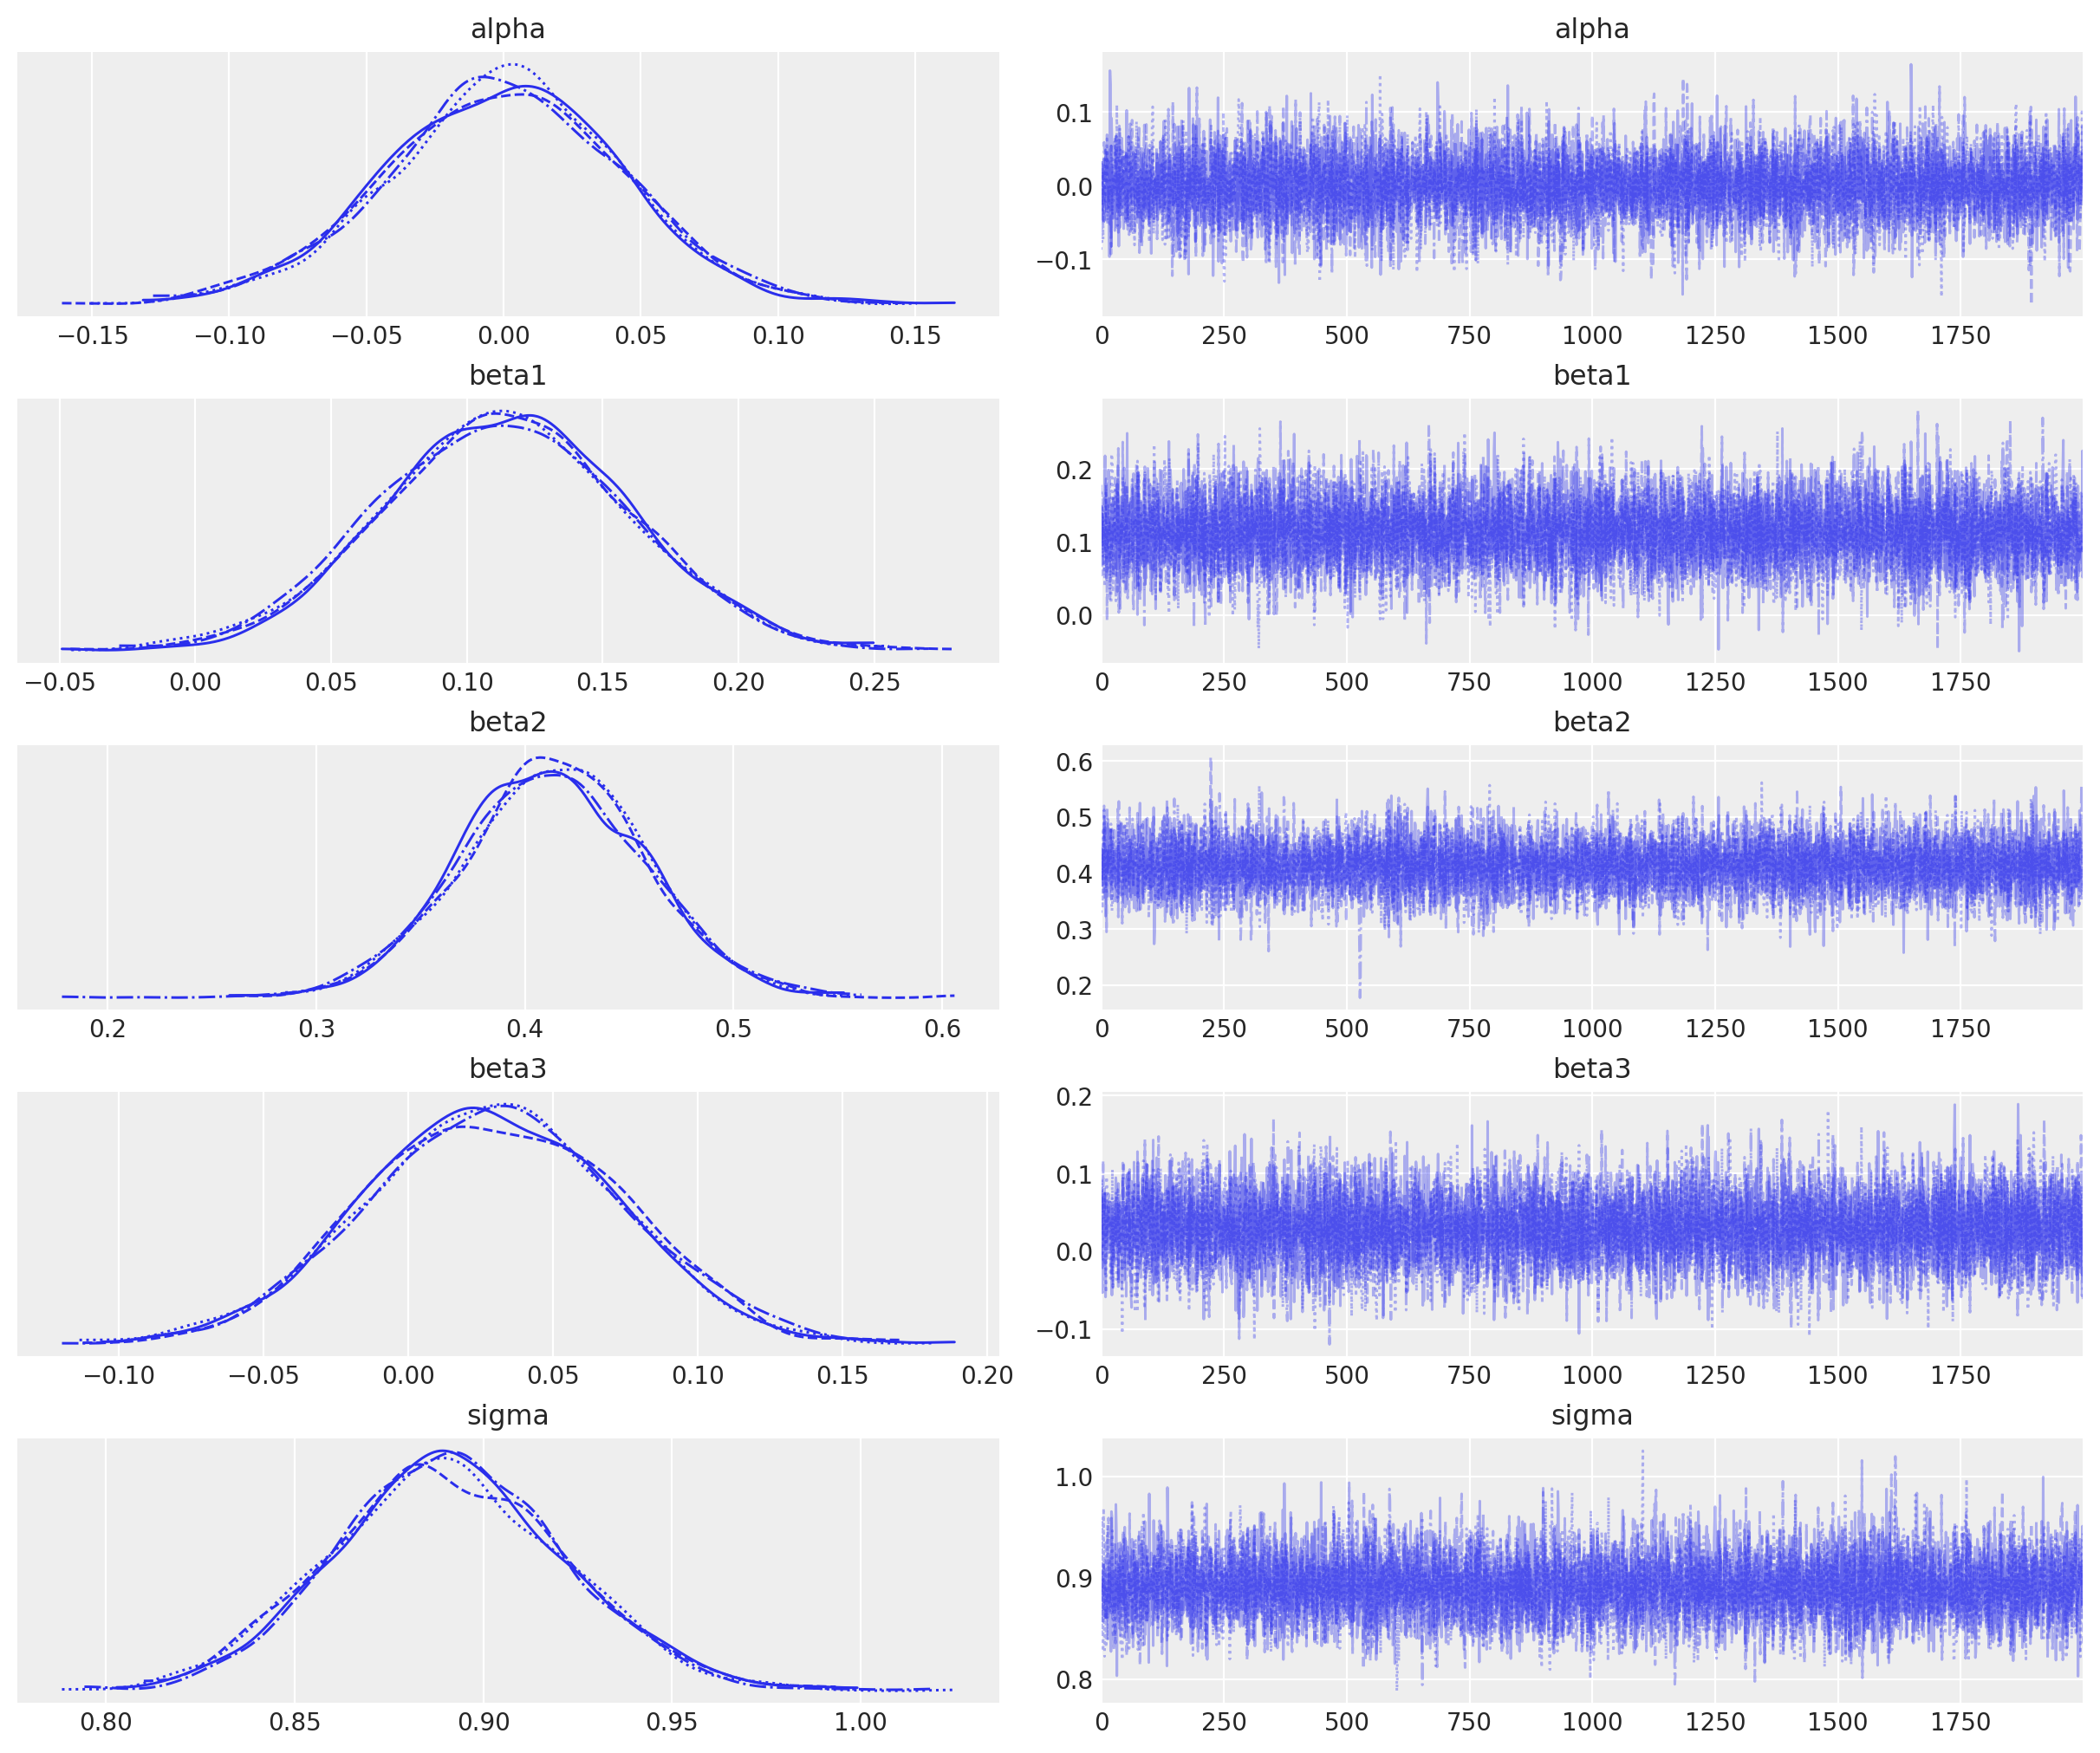

In [33]:
_ = az.plot_trace(fit, var_names=(["alpha", "beta1", "beta2", "beta3", "sigma"]))

Anche nel caso della regressione multipla, i risultati ottenuti con l'approccio bayesiano sono molto simili a quelli prodotti dall'approccio basato sulla massima verosimiglianza.

Calcoliamo una sintesi delle distribuzioni a posteriori dei parametri:

In [34]:
az.summary(
    fit, var_names=(["alpha", "beta1", "beta2", "beta3", "sigma"]), hdi_prob=0.94
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.043,-0.082,0.080,0.0,0.001,9553.0,5261.0,1.0
beta1,0.114,0.045,0.031,0.201,0.0,0.000,9409.0,6308.0,1.0
beta2,0.414,0.044,0.330,0.496,0.0,0.000,9556.0,6280.0,1.0
beta3,0.029,0.043,-0.050,0.112,0.0,0.000,9647.0,6545.0,1.0
sigma,0.891,0.031,0.835,0.949,0.0,0.000,9403.0,5961.0,1.0


Replichiamo il risultato usando l'approccio di massima verosimiglianza:

In [35]:
lm = pg.linear_regression(X, stats.zscore(kidiq["kid_score"]))
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.00,0.04,-0.00,1.00,0.21,0.21,-0.08,0.08
1,x2,0.11,0.05,2.50,0.01,0.21,0.21,0.02,0.20
2,x3,0.41,0.04,9.28,0.00,0.21,0.21,0.33,0.50
3,x4,0.03,0.04,0.68,0.50,0.21,0.21,-0.06,0.12


## Interpretazione dei coefficienti

Nel contesto della regressione multipla, l'interpretazione dei coefficienti parziali differisce da quella della regressione bivariata. Una differenza chiave rispetto al modello di regressione bivariato è nell'interpretazione dei coefficienti. Nel caso bivariato, il coefficiente $\beta_1$ viene interpretato come il cambiamento atteso in $Y$ al variare di una unità in $X_1$. Tuttavia, nel modello di regressione multipla, l'interpretazione di $\beta_1$ cambia. In questo caso, $\beta_1$ rappresenta il cambiamento atteso in $Y$ al variare di una unità in $X_1$, mantenendo costanti gli effetti di tutte le altre variabili $X_2, X_3, \ldots, X_p$. In altre parole, $\beta_1$ ci dice come varia in media $Y$ quando $X_1$ cambia, ma considera che altre variabili possono variare insieme a $X_1$, e $\beta_1$ tiene conto di queste variazioni.

Nel nostro caso, il coefficiente associato all'intelligenza della madre, indicato come $\beta$ = 0.41, assume il seguente significato: prevediamo che l'intelligenza del bambino aumenti di 0.41 deviazioni standard in media per ogni deviazione standard aggiuntiva nell'intelligenza della madre, mantenendo costanti gli effetti del livello di istruzione e dell'età della madre. Questo implica che stiamo considerando l'impatto dell'intelligenza della madre sull'intelligenza del bambino all'interno di una popolazione di madri che sono omogenee per quanto riguarda il livello di istruzione e l'età.

Cosa significa mantenere costante l'effetto di altre variabili? Consideriamo l'esempio della correlazione tra il numero di scarpe e le abilità matematiche. Esiste una marcata correlazione positiva tra queste due variabili. Tuttavia, è evidente che i bambini, avendo in genere numeri di scarpe più piccoli rispetto agli adulti, mostrano anche, presumibilmente, minori capacità matematiche. Questo esempio illustra che, se controlliamo per l'età, ossia se consideriamo solo soggetti della stessa età, la correlazione tra il numero di scarpe e le abilità matematiche scompare. Pertanto, nell'analisi della relazione tra abilità matematiche (Y) e numero di scarpe (X), l'età (Z) agisce come variabile confondente. Controllare per Z significa esaminare la relazione tra Y e X limitandosi a individui della stessa età.

Ma ovviamente questo controllo empirico non è sempre possibile. Nel modello di regressione, esso viene "approssimato" con una procedura statistica. 

## Distribuzione predittiva a posteriori

Calcoliamo la distribuzione predittiva a posteriori e generiamo il PPC plot:

In [37]:
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_rep',
    observed_data={'y': stats.zscore(kidiq["kid_score"])},
)

/opt/anaconda3/envs/cmdstan_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


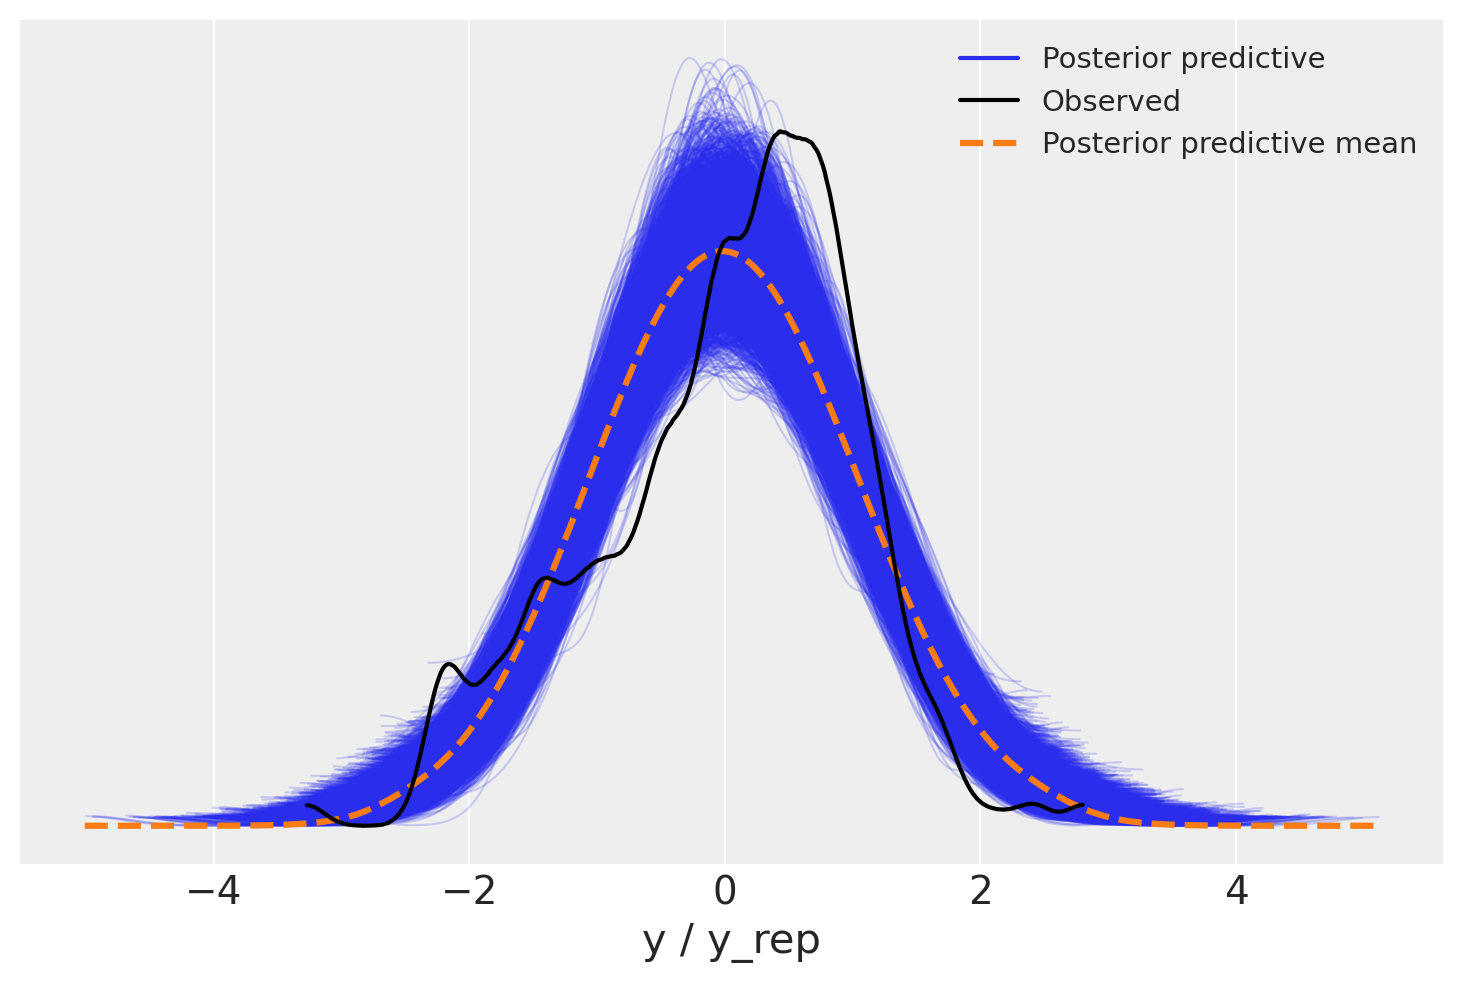

In [38]:
_ = az.plot_ppc(idata, data_pairs={'y': 'y_rep'})

## Il Controllo Statisico

Nella seguente simulazione illustreremo la procedura statistica utilizzata per isolare l'effetto di una variabile controllando per un'altra. 

In [28]:
# Creiamo dei dati di esempio
np.random.seed(0)
N = 100
X1 = np.random.normal(0, 1, N)
X2 = X1 + np.random.normal(0, 0.5, N)
Y = 1 + 2 * X1 + 3 * X2 + np.random.normal(0, 1, N)

# Modello completo Y ~ X1 + X2
model_full = sm.OLS(Y, sm.add_constant(np.column_stack((X1, X2))))
results_full = model_full.fit()

# Regressione di Y su X2
model_Y_on_X2 = sm.OLS(Y, sm.add_constant(X2))
residuals_Y = model_Y_on_X2.fit().resid

# Regressione di X1 su X2
model_X1_on_X2 = sm.OLS(X1, sm.add_constant(X2))
residuals_X1 = model_X1_on_X2.fit().resid

# Regressione dei residui di Y sui residui di X1
model_residuals = sm.OLS(residuals_Y, sm.add_constant(residuals_X1))
results_residuals = model_residuals.fit()

# Stampiamo i risultati
print("Coefficient from full model for X1: {:.4f}".format(results_full.params[1]))
print(
    "Coefficient from regression of residuals: {:.4f}".format(
        results_residuals.params[1]
    )
)

Coefficient from full model for X1: 1.9782
Coefficient from regression of residuals: 1.9782


Questo esempio illustra il concetto di *coefficiente parziale di regressione*. Questo coefficiente quantifica l'effetto della variabile esplicativa $X_j$ sulla variabile dipendente $Y$, depurando l'effetto di $X_j$ dall'influenza degli altri predittori nel modello. In sostanza, il coefficiente parziale di regressione valuta l'impiego di $X_j$ su $Y$ quando $X_j$ è considerata *linearmente indipendente* rispetto agli altri predittori $X$. L'effetto misurato è quindi quello della sola componente di $X_j$ che non è spiegata linearmente dai restanti predittori $X$ sulla parte di $Y$ che è anch'essa indipendente dai medesimi predittori.

Per chiarire ulteriormente, questo approccio statistico si focalizza sull'analizzare l'effetto di $X_j$ eliminando l'influenza lineare degli altri predittori $X$. È simile a valutare la relazione tra $Y$ e $X_j$ in un contesto ideale dove tutti gli individui presentano livelli identici per le altre variabili $X$. Tale metodo non eguaglia gli effetti non lineari che possono essere presenti tra le variabili, limitandosi a correggere solo per le associazioni lineari. In questo modo, il controllo statistico tenta di approssimare una condizione di omogeneità tra i soggetti rispetto alle altre variabili $X$, consentendo di isolare e valutare più precisamente l'effetto puro di $X_j$ su $Y$.

## Quali predittori includere nel modello?

L'utilizzo del modello di regressione multipla ha principalmente due scopi. In primo luogo, è utilizzato per la predizione, cioè per ottenere la migliore stima possibile di $Y$ utilizzando una combinazione lineare delle variabili $X_1, X_2, \ldots, X_p$. In questo contesto, i coefficienti $\beta_i$ sono considerati come pesi che permettono di effettuare questa previsione.

In secondo luogo, il modello di regressione multipla viene spesso utilizzato per descrivere le relazioni causali tra le variabili. Tuttavia, è importante sottolineare che questo modello non è stato originariamente creato per stabilire relazioni causali, ed è necessario essere cauti nell'attribuire interpretazioni causali dirette ai coefficienti $\beta_i$. Questo perché il modello stima correttamente i coefficienti parziali di regressione solo quando tutte le variabili che influenzano $Y$ sono incluse nel modello. Nella pratica, spesso non conosciamo tutte le variabili causalmente rilevanti, il che può portare a problemi di errore di specificazione.

I modello di regressione multipla rappresenta uno strumento potente per predire e analizzare le relazioni tra variabili. Tuttavia, è fondamentale riconoscerne le limitazioni, specialmente quando si tentano interpretazioni causali. In ambiti come la psicologia, dove è cruciale comprendere le dinamiche causali, diventa essenziale una scelta accurata delle variabili da includere nel modello per prevenire distorsioni nelle stime dei coefficienti di regressione.

Tradizionalmente, si riteneva vantaggioso includere nel modello il maggior numero possibile di variabili per ottenere un livello di "controllo" statistico più elevato. Tuttavia, come sottolineato da @McElreath_rethinking, questo metodo può trasformarsi in una "insalata causale". Questo termine descrive una situazione in cui la mancanza di attenzione alla struttura causale tra le variabili può portare all'inclusione di variabili di controllo inappropriate, causando distorsioni nelle stime.

In alcuni casi, l'inserimento di determinate variabili di controllo nel modello è indispensabile per evitare distorsioni, mentre in altri casi, l'inclusione di variabili non pertinenti può portare a risultati fuorvianti. Questo enfatizza l'importanza di formulare ipotesi chiare e ben ponderate sulla struttura causale che intercorre tra le variabili in esame.

L'efficacia e la validità dei risultati ottenuti tramite regressione dipendono strettamente dalla correttezza delle ipotesi causali formulate, sia esplicitamente che implicitamente, dal ricercatore. Pertanto, per superare i limiti dell'approccio dell'"insalata causale", è cruciale che la formulazione del modello di regressione rifletta attentamente tali ipotesi causali.

## Considerazioni conclusive 

Nel suo libro *Statistical Rethinking*, @McElreath_rethinking introduce l'idea di modelli statistici paragonandoli ai Golem, antiche creature della mitologia, prive di volontà propria e animate solo dall'intento di chi le crea. Questi enti, pur essendo dotati di grande forza, possono diventare pericolosi se non guidati con saggezza.

@McElreath_rethinking sostiene che gli scienziati, nella creazione di modelli matematici e software, diano vita a moderni equivalenti di questi Golem. Questi modelli, sebbene influenzino il mondo reale tramite le loro previsioni e le intuizioni che generano, non dovrebbero essere considerati né completamente veritieri né falsi. Essi sono piuttosto strumenti sviluppati con uno scopo specifico, capaci di operare calcoli con estrema precisione, ma privi della capacità di comprendere o interpretare il contesto più ampio in cui sono applicati.

In particolare, il modello di regressione viene esaminato come esempio di come tali strumenti possano produrre risultati concreti, ma manchino di adattabilità e giudizio autonomo, limitando la loro efficacia nel trattare questioni che richiedono un approccio più creativo e comprensivo. @McElreath_rethinking enfatizza ulteriormente che nessun strumento statistico, da solo, è sufficiente per affrontare adeguatamente il complesso problema dell'inferenza causale a partire da dati empirici. Questi modelli, privi di una reale comprensione delle dinamiche di causa ed effetto, si limitano a descrivere relazioni tra variabili. Senza un'interpretazione critica e un orientamento consapevole da parte degli scienziati, questi strumenti, creati per fini ben definiti, possono rivelarsi non solo inefficaci, ma anche potenzialmente dannosi.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -m 

Last updated: Wed Jul 17 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.2.2
arviz      : 0.18.0
matplotlib : 3.9.1
cmdstanpy  : 1.2.4
pingouin   : 0.5.4
scipy      : 1.14.0
statsmodels: 0.14.2
numpy      : 1.26.4
logging    : 0.5.1.2

Watermark: 2.4.3

